<a href="https://colab.research.google.com/github/Maagnitude/CRC_slides_models/blob/main/CRC_slides_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2η Εργασία** στο μάθημα **Μηχανική Μάθηση και Εφαρμογές**

# **Τμήμα Πληροφορικής και Τηλεματικής - Χαροκόπειο Πανεπιστήμιο**

# **Καζάζης Γεώργιος - it214124**

Στην παρούσα εργασία θα αναπτύξουμε **μοντέλα Συνελικτικών Νευρωνικών Δικτύων**, για να κατηγοριοποιήσουμε όσο πιο σωστά γίνεται τις 7180 εικόνες μικροσκοπίου, στις 9 κλάσεις που έχουμε.

**Αρχίζοντας...**

# **Βιβλιοθήκες**
Κάνουμε import τα απαραίτητα **modules**. 
*   Την **pandas** και την **numpy** για την διαχείρηση των δεδομένων μας.

*  Την **matplotlib.pyplot** και την **seaborn** για την οπτικοποίηση των δεδομένων μας. **Ιστογράμματα**, **boxplots** κλπ.

*  Την **missingno** ώστε να οπτικοποιήσουμε το αν υπάρχουν ελλιπείς εγγραφές.

*   Από την **sklearn** κάνουμε import:
      *   Την **linear_model** για να εκπαιδεύσουμε το **Logistic Regression model**.
      *   Την **neural_network** για να υλοποιήσουμε και να εκπαιδεύσουμε ΤΝΔ.
      *  Την **StardardScaler** και την **train_test_split** για το **Preprocessing** κομμάτι. Συγκεκριμένα για την τυποποίηση των δεδομένων και για να χωρίσουμε τα δεδομένα μας σε **test data** και **train data**.
      *  Την **metrics** για τις μετρικές που θα χρησιμοποιήσουμε, όπως η **confusion_matrix**.
      *  Την **RandomForestClassifier** για να εκπαιδεύσουμε ένα Random Forest model.
*  Το **tensorflow**, και από αυτό, τα **keras** και **layers** για την ανάπτυξη νευρωνικών δικτύων.

*  Τέλος, κάνουμε import τα **warnings** και τα φιλτράρουμε, ώστε να μην εμφανίζονται.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.datasets

## **drive mount και μεταφόρτωση των εικόνων**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/CRC_slides.tar.gz' .
!tar -xvzf 'CRC_slides.tar.gz'
data_dir = '/content/CRC_slides'

# **Υλοποίηση συνάρτησης για ...**

In [43]:
def load_dataset(data_dir, train_pct=0.6, val_pct=0.2, test_pct=0.2, batch_size=64, img_size=(224, 224)):
    
  all_ds = keras.utils.image_dataset_from_directory(data_dir, labels='inferred', label_mode='int', class_names=None, 
                              color_mode='rgb', batch_size=batch_size, image_size=img_size, shuffle=True, seed=123)

  # Split the data into training, validation, and test sets
  num_samples = len(all_ds)
  train_size = int(train_pct * num_samples)
  val_size = int(val_pct * num_samples)
  test_size = int(test_pct * num_samples)
  devel_size = num_samples - train_size - val_size - test_size
  devel_ds = all_ds.take(devel_size)
  train_ds = all_ds.skip(devel_size).take(train_size)
  val_ds = all_ds.skip(devel_size + train_size).take(val_size)
  test_ds = all_ds.skip(devel_size + train_size + val_size).take(test_size)

  classes = all_ds.class_names

  return devel_ds, train_ds, val_ds, test_ds, classes

In [44]:
devel_ds, train_ds, val_ds, test_ds, classes = load_dataset(data_dir)

Found 7180 files belonging to 9 classes.


['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

## **Παρακάτω οπτικοποιούμε τον αριθμό των αρχείων κάθε κατηγορίας στο σύνολο ανάπτυξης**.

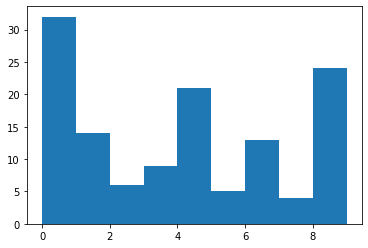

In [45]:
y = np.concatenate([y for x, y in devel_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

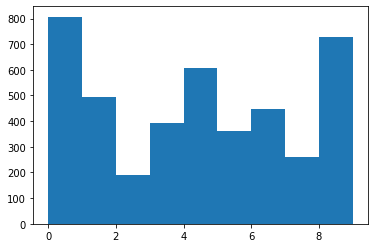

In [46]:
y = np.concatenate([y for x, y in train_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

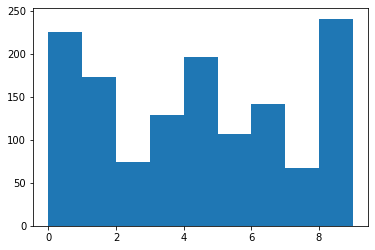

In [47]:
y = np.concatenate([y for x, y in test_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

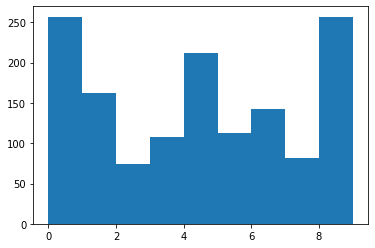

In [48]:
y = np.concatenate([y for x, y in val_ds])
plt.hist(y, list(range(len(classes) + 1)))
plt.show()

In [ ]:
def cnn(num_classes):
  